In [39]:
import datacube as dc
import numpy as np
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
import datetime as datetime
import xarray as xr
import multiprocessing as mp
import pickle
import ctypes
from contextlib import closing
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def dist_geomedian(params):
    """
    distributed version of geomedian
    """
    gmed = np.frombuffer(shared_out_arr.get_obj(), dtype=np.float32).reshape((params[2][0],params[2][2]))
    X = np.frombuffer(shared_in_arr.get_obj(), dtype=np.int16).reshape(params[2])
    
    for i in range(params[0], params[1]):
        ind = np.where(X[1,:,i]>0)[0]
        if len(ind)>0:
            gmed[:,i] = geometric_median(X[:,ind,i], 1, 40)
        

In [3]:
def dist_distance(params):
    """
    distributed version of cosine distances and nbr distances
    """
    X =  np.frombuffer(shared_in_arr1.get_obj(), dtype=np.int16).reshape(params[2])
    gmed = np.frombuffer(shared_in_arr2.get_obj(), dtype=np.float32).reshape((params[2][0],params[2][2]))    
    cos_dist = np.frombuffer(shared_out_arr1.get_obj(), dtype=np.float32).reshape((params[2][1],params[2][2]))
    nbr_dist = np.frombuffer(shared_out_arr2.get_obj(), dtype=np.float32).reshape((params[2][1],params[2][2]))
    direction = np.frombuffer(shared_out_arr3.get_obj(), dtype=np.int16).reshape((params[2][1],params[2][2]))
    #print(X, gmed)
    for i in range(params[0], params[1]):
        #print(i)
        #if i%10000==0:
        #    print(i)
        ind=np.where(X[1,:,i]>0)[0] 
        
        if len(ind)>0:
            cos_dist[ind,i] = cos_distance(gmed[:,i], X[:,ind,i])
            nbrmed = (gmed[3,i]-gmed[5,i])/ (gmed[3,i]+gmed[5,i])
            nbr = (X[3,:,i]-X[5,:,i])/(X[3,:,i]+X[5,:,i])
            nbr_dist[ind,i],direction[ind,i] = nbr_eucdistance(nbrmed,nbr[ind])  
            #print(gmed[:,i], cos_distance(gmed[:,i], X[:,ind,i]))

In [4]:
def geometric_median(x, epsilon=1, max_iter=40):
    """
    Calculates the geometric median of band reflectances
    The procedure stops when either the error tolerance 'tol' or the maximum number of iterations 'MaxIter' is reached. 
    Args:
        x: (p x N) matrix, where p = number of bands and N = number of dates during the period of interest
        max_iter: maximum number of iterations
        tol: tolerance criterion to stop iteration   
    
    Returns:
        geo_median: p-dimensional vector with geometric median reflectances
    """
    y0 = np.nanmean(x, axis=1)
    if len(y0[np.isnan(y0)]) > 0:
        return y0

    for _ in range(max_iter):
        euc_dist = np.transpose(np.transpose(x) - y0)
        euc_norm = np.sqrt(np.sum(euc_dist ** 2, axis=0))
        not_nan = np.where(~np.isnan(euc_norm))[0]
        y1 = np.sum(x[:, not_nan] / euc_norm[not_nan], axis=1) / (np.sum(1 / euc_norm[not_nan]))
        if len(y1[np.isnan(y1)]) > 0 or np.sqrt(np.sum((y1 - y0) ** 2)) < epsilon:
            return y1
      
        y0 = y1
        
    return y0


In [5]:
def cos_distance(ref, obs):
    """
    Returns the cosine distance between observation and reference
    The calculation is point based, easily adaptable to any dimension. 
    Args:
        ref: reference (2-D array with multiple days) e.g., geomatrix median [Nbands]
        obs: observation (with multiple bands, e.g. 6) e.g.,  monthly geomatrix median or reflectance [Nbands,ndays]
    
    Returns:
        cosdist: the cosine distance at each time step in [ndays]
    """
    ref = ref.astype('float32')
    obs = obs.astype('float32')
    cosdist = np.empty((obs.shape[1],))
    cosdist.fill(np.nan)
    index = np.where(~np.isnan(obs[0, :]))[0]
    cosdist[index] = np.transpose([1 - np.sum(ref * obs[:, t]) / (np.sqrt(np.sum(ref ** 2)) * np.sqrt(np.sum(obs[:, t] ** 2))) for t in index])
    #print(cosdist)
    return cosdist

In [6]:
def nbr_eucdistance(ref, obs):
    """
    Returns the euclidean distance between the NBR at each time step with the NBR calculated from the geometric medians
    and also the direction of change to the NBR from the geometric medians.
    
    Args:
        ref: NBR calculated from geometric median, one value
        obs: NBR time series, 1-D time series array with ndays 
    
    Returns:
        nbr_dist: the euclidean distance 
        direction: change direction (1: decrease; 0: increase) at each time step in [ndays]
    """
    nbr_dist = np.empty((obs.shape[0],))
    direction = np.zeros((obs.shape[0],),dtype='uint8')
    nbr_dist.fill(np.nan)
    index = np.where(~np.isnan(obs))[0]
    euc_dist = (obs[index] - ref)
    euc_norm = np.sqrt((euc_dist ** 2))
    nbr_dist[index] = euc_norm
    direction[index[euc_dist< -0.05]] = 1
    
    return nbr_dist, direction



In [17]:
def severity(data, method='NBRdist'):
    """
    Returns the severity,duration and start date of the change.   
    Args:
        
        time: dates of observations
        data: xarray including the cosine distances, NBR distances, NBR, change direction and outliers value
        method: 1,2,3 to choose
            1: only use cosine distance as an indicator for change
            2: use cosine distance together with NBR<0
            3: use both cosine distance, NBR euclidean distance, and NBR change direction for change detection
        
    Returns:
        sevindex: severity
        startdate: first date change was detected 
        duration: duration between the first and last date the change exceeded the outlier threshold
    """
    sevindex = 0
    startdate = 0
    duration = 0
    time = data.time
    notnanind = np.where(~np.isnan(data.CosDist))[0]  # remove the nan values for each pixel
   
    if method == 'NBR':  # cosdist above the line and NBR<0
        try:
            data.CosDist
            data.NBR            
            data.CDistoutlier
        except NameError:
            print('Cosine distance and NBR are required')
            
        
        outlierind = np.where((data.CosDist[notnanind] > data.CDistoutlier) & (data.NBR[notnanind] < 0))[0]
        cosdist = data.CosDist[notnanind]
    elif method == 'NBRdist':  # both cosdist and NBR dist above the line and it is negative change
        try:
            data.CosDist
            data.NBRDist
            data.ChangeDir
            data.CDistoutlier
            data.NBRoutlier
        except NameError:
            print('Cosine distance are NBR distance are required')
        
        
        outlierind = np.where((data.CosDist[notnanind] > data.CDistoutlier) &
                              (data.NBRDist[notnanind] > data.NBRoutlier) &
                              (data.ChangeDir[notnanind] == 1))[0]

        cosdist = data.CosDist.data[notnanind]
    else:
        raise ValueError

    time = time.data[notnanind]
    outlierdates = time[outlierind]
    n_out = len(outlierind)
    area_above_d0 = 0
    if n_out >= 2:
        tt = []
        for ii in range(0, n_out):
            if outlierind[ii] + 1 < len(time):
                u = np.where(time[outlierind[ii] + 1] == outlierdates)[0]  # next day have to be outlier to be included
                # print(u)

                if len(u) > 0:
                    t1_t0 = (time[outlierind[ii] + 1] - time[outlierind[ii]]) / np.timedelta64(1, 's') / (60 * 60 * 24)
                    y1_y0 = (cosdist[outlierind[ii] + 1] + cosdist[outlierind[ii]]) - 2 * data.CDistoutlier.data
                    area_above_d0 = area_above_d0 + 0.5 * y1_y0 * t1_t0  # calculate the area under the curve
                    duration = duration + t1_t0
                    tt.append(ii)  # record the index where it is detected as a change

        if len(tt) > 0:
            startdate = time[outlierind[tt[0]]]  # record the date of the first change
            sevindex = area_above_d0

    return sevindex, startdate, duration


In [8]:
def outline_to_mask(line, x, y):
    """Create mask from outline contour

    Parameters
    ----------
    line: array-like (N, 2)
    x, y: 1-D grid coordinates (input for meshgrid)

    Returns
    -------
    mask : 2-D boolean array (True inside)

    Examples
    --------
    >>> from shapely.geometry import Point
    >>> poly = Point(0,0).buffer(1)
    >>> x = np.linspace(-5,5,100)
    >>> y = np.linspace(-5,5,100)
    >>> mask = outline_to_mask(poly.boundary, x, y)
    """
    import matplotlib.path as mplp
    mpath = mplp.Path(line)
    X, Y = np.meshgrid(x, y)
    points = np.array((X.flatten(), Y.flatten())).T
    mask = mpath.contains_points(points).reshape(X.shape)
    return mask


In [36]:
def hotspot_polygon(year,extent,buffersize):
    """Create polygons for the hotspot with a buffer
    year: given year for hotspots data
    extent: [xmin,xmax,ymin,ymax] in crs EPSG:3577
    buffersize: in meters
    
    Examples:
    ------------
    >>>year=2017
    >>>extent = [1648837.5, 1675812.5, -3671837.5, -3640887.5]
    >>>polygons = hotspot_polygon(year,extent,4000)
    """
    import glob
    import pyproj
    import pandas as pd
    datafile = '/g/data/xc0/original/GA_SentinelHotspots/hotspot_historic_*.csv'
    gda94aa = pyproj.Proj(init='epsg:3577')#,py_list='aea')
    gda94 = pyproj.Proj(init='epsg:4283')

    if year==2005:
        name = '/g/data/xc0/original/GA_SentinelHotspots/hotspot_historic_2005-2010.csv'
        table = pd.read_csv(name)

    elif year == 2010:
        name = '/g/data/xc0/original/GA_SentinelHotspots/hotspot_historic_2010-2015.csv'
        table = pd.read_csv(name)

    else:
        for i in range(0,len(glob.glob(datafile))):
            name = glob.glob(datafile)[i]
            startyear = int(name[-13:-9])
            endyear = int(name[-8:-4])
            if (year<=endyear )& (year>=startyear):
                table = pd.read_csv(name)
                break

    start = np.datetime64(datetime.datetime(year,1,1))
    stop =  np.datetime64(datetime.datetime(year,12,31))
    dates=table.datetime.values.astype('datetime64')
    lon,lat=pyproj.transform(gda94aa,gda94,extent[0:2],extent[2:4])
    index = np.where((dates>=start)*(dates<=stop)*(table.latitude<=lat[1])*(table.latitude>=lat[0])*(table.longitude<=lon[1])*(table.longitude>=lon[0]) )[0]
    latitude = table.latitude.values[index]
    longitude = table.longitude.values[index]        
    easting,northing=pyproj.transform(gda94,gda94aa,longitude,latitude)
    
    from shapely.ops import cascaded_union
    from matplotlib.patches import Polygon
    from shapely.geometry import Point
    
   
    patch = [Point(easting[i],northing[i]).buffer(buffersize) for i in range(0,len(index))]
    polygons = cascaded_union(patch)
    return polygons


In [31]:
class BurnCube(dc.Datacube):
    def __init__(self):
        super(BurnCube, self).__init__(app='TreeMapping.getLandsatStack')

        self.dataset = None
        self.geomed = None
        self.dists = None
        self.outlrs = None
        self.severity = None

    def to_netcdf(self, path):
        #fileObject = open(path,'wb') 
        #pickle.dump(self.dataset, fileObject)
        self.dataset.to_netcdf(path)

    def open_dataset(self, path):
        #fileObject = open(path,'r')  
        #self.dataset = pickle.load(fileObject)
        self.dataset = xr.open_dataset(path)
    
    def geomed_to_netcdf(self, path):
        #fileObject = open(path,'wb') 
        #pickle.dump(self.dataset, fileObject)
        self.geomed.to_netcdf(path)

    def open_geomed(self, path):
        #fileObject = open(path,'r')  
        #self.dataset = pickle.load(fileObject)
        self.geomed = xr.open_dataset(path)
         
    def _load_pq(self, x, y, res, period, n_landsat):
        query = {
            'time': period,
            'x': x,
            'y': y,
            'crs':'EPSG:3577',
            'measurements' : ['pixelquality'],
            'resolution': res,
        }
        
        pq_stack = []
        for n in n_landsat:
            pq_stack.append(self.load(product='ls{}_pq_albers'.format(n), 
                                      group_by='solar_day', fuse_func=ga_pq_fuser, 
                                      resampling='nearest', **query))
        
        pq_stack = xr.concat(pq_stack, dim='time').sortby('time')
        
        pq_stack['land'] = masking.make_mask(pq_stack.pixelquality, land_sea='land')
        pq_stack['no_cloud'] = masking.make_mask(pq_stack.pixelquality, cloud_acca='no_cloud', 
                                                 cloud_fmask='no_cloud', cloud_shadow_acca='no_cloud_shadow',
                                                 cloud_shadow_fmask='no_cloud_shadow')
    
        
        return pq_stack
    
        
    def _load_nbart(self, x, y, res, period, n_landsat):
        query = {
            'time': period,
            'x': x,
            'y': y,
            'crs': 'EPSG:3577',
            'measurements' : ['red','green','blue','nir','swir1','swir2'],
            'resolution': res,
        }
        
        nbart_stack = []
        for n in n_landsat:
            dss = self.find_datasets(product='ls{}_nbart_albers'.format(n), **query)
            nbart_stack.append(self.load(product='ls{}_nbart_albers'.format(n),
                                         group_by='solar_day', datasets=dss, resampling='bilinear',
                                         **query))
        
        nbart_stack = xr.concat(nbart_stack, dim='time').sortby('time')
        
        return nbart_stack
        
        
    def load_cube(self, x, y, res, period, n_landsat):
        
        nbart_stack = self._load_nbart(x, y, res, period, n_landsat)
        pq_stack = self._load_pq(x, y, res, period, n_landsat)
        
        pq_stack, nbart_stack = xr.align(pq_stack, nbart_stack, join='inner') 
        pq_stack['good_pixel'] = pq_stack.no_cloud.where(nbart_stack.red > 0, False, drop=False)
        
        goodpix = pq_stack.no_cloud * (pq_stack.pixelquality > 0) * pq_stack.good_pixel
        
        
        mask = np.nanmean(goodpix.values.reshape(goodpix.shape[0], -1), axis=1) > .2


        cubes = [nbart_stack[band][mask, :, :]*goodpix[mask, :, :] for band in ['red','green','blue','nir','swir1','swir2']]
        X = np.stack(cubes, axis=0)

        
        #data = xr.Dataset(coords={'band': ['red','green','blue','nir','swir1','swir2'],
        data = xr.Dataset(coords={'band': np.arange(6),
                                  'time':nbart_stack.time[mask],
                                  'y':nbart_stack.y[:],
                                  'x':nbart_stack.x[:]},
                          attrs={'crs':'EPSG:3577'})
        data["cube"] = (('band','time','y','x'),X)
        data.time.attrs=[]
        
        self.dataset = data

    def geomedian(self, period, n_procs=4, epsilon=.5, max_iter=40):
        # Define an output queue
       
        n = len(self.dataset.y)*len(self.dataset.x)
        out_arr = mp.Array(ctypes.c_float, len(self.dataset.band)*n)
        gmed = np.frombuffer(out_arr.get_obj(), dtype=np.float32).reshape((len(self.dataset.band),n))
        gmed.fill(np.nan)
    
        _X = self.dataset['cube'].sel(time=slice(period[0],period[1]))
        #print(_X.shape)
        t_dim = _X.time[:]
        in_arr = mp.Array(ctypes.c_short, len(self.dataset.band)*len(_X.time)*n)
        X = np.frombuffer(in_arr.get_obj(), dtype=np.int16).reshape(len(self.dataset.band), len(_X.time), n)
        X[:] = _X.data.reshape(len(self.dataset.band), len(_X.time), -1)

        def init(shared_in_arr_, shared_out_arr_):
            global shared_in_arr
            global shared_out_arr
            shared_in_arr = shared_in_arr_ # must be inherited, not passed as an argument
            shared_out_arr = shared_out_arr_ # must be inherited, not passed as an argument


        # write to arr from different processes
        with closing(mp.Pool(initializer=init, initargs=(in_arr, out_arr,))) as p:
        # many processes access different slices of the same array
            chunk = n//n_procs
            #p.map_async(g, [(i, i + step) for i in range(0, N, step)])
            p.map_async(dist_geomedian, [(i, min(n, i+chunk), X.shape) for i in range(0, n, chunk)])
        p.join()
        
        ds = xr.Dataset(coords={'time':t_dim,'y':self.dataset.y[:],'x':self.dataset.x[:],'bands':self.dataset.band}, attrs={'crs':'EPSG:3577'})
        ds['geomedian'] = (('bands','y','x'),gmed[:].reshape((len(self.dataset.band),len(self.dataset.y),len(self.dataset.x))).astype(np.float32))
        
        del gmed, in_arr, out_arr, X
        self.geomed = ds
        
    def distances(self, period, n_procs=4):
        n = len(self.dataset.y)*len(self.dataset.x)
        _X = self.dataset['cube'].sel(time=slice(period[0],period[1]))
        
        t_dim = _X.time.data
        nir = _X[3,:,:,:].data.astype('float32')
        swir2 = _X[5,:,:,:].data.astype('float32')
        nir[nir<=0]=np.nan
        swir2[swir2<=0]=np.nan
        nbr = ((nir-swir2) / (nir+swir2))
        print(nbr.shape)
        
        out_arr1 = mp.Array(ctypes.c_float, len(t_dim)*n)
        out_arr2 = mp.Array(ctypes.c_float, len(t_dim)*n)
        out_arr3 = mp.Array(ctypes.c_short, len(t_dim)*n)
        
        cos_dist = np.frombuffer(out_arr1.get_obj(), dtype=np.float32).reshape((len(t_dim),n))
        cos_dist.fill(np.nan)
        nbr_dist = np.frombuffer(out_arr2.get_obj(), dtype=np.float32).reshape((len(t_dim),n))
        nbr_dist.fill(np.nan)
        direction = np.frombuffer(out_arr3.get_obj(), dtype=np.int16).reshape((len(t_dim),n))
        direction.fill(0)
        
        in_arr1 = mp.Array(ctypes.c_short, len(self.dataset.band)*len(_X.time)*n)
        X = np.frombuffer(in_arr1.get_obj(), dtype=np.int16).reshape(len(self.dataset.band), len(_X.time), n)
        X[:] = _X.data.reshape(len(self.dataset.band), len(_X.time), -1)
        
        in_arr2 = mp.Array(ctypes.c_float, len(self.dataset.band)*n)        
        gmed = np.frombuffer(in_arr2.get_obj(), dtype=np.float32).reshape(len(self.dataset.band), n)
        gmed[:] = self.geomed['geomedian'].data.reshape(len(self.dataset.band),  -1)
        
        
        def init(shared_in_arr1_, shared_in_arr2_, shared_out_arr1_, shared_out_arr2_, shared_out_arr3_):
            global shared_in_arr1
            global shared_in_arr2
            global shared_out_arr1
            global shared_out_arr2
            global shared_out_arr3
            
            shared_in_arr1 = shared_in_arr1_ # must be inherited, not passed as an argument            
            shared_in_arr2 = shared_in_arr2_ # must be inherited, not passed as an argument
            shared_out_arr1 = shared_out_arr1_ # must be inherited, not passed as an argument
            shared_out_arr2 = shared_out_arr2_ # must be inherited, not passed as an argument           
            shared_out_arr3 = shared_out_arr3_ # must be inherited, not passed as an argument
            
         # write to arr from different processes
        with closing(mp.Pool(initializer=init, initargs=(in_arr1, in_arr2, out_arr1, out_arr2, out_arr3,))) as p:
        # many processes access different slices of the same array
            chunk = n//n_procs
      
            p.map_async(dist_distance, [(i, min(n, i+chunk), X.shape) for i in range(0, n, chunk)])
            
        p.join()
       
        
        
        ds = xr.Dataset(coords={'time':t_dim,'y':self.dataset.y[:],'x':self.dataset.x[:],'bands':self.dataset.band}, attrs={'crs':'EPSG:3577'})
        ds['cosdist'] = (('time','y','x'),cos_dist[:].reshape((len(t_dim),len(self.dataset.y),len(self.dataset.x))).astype('float32'))
        ds['NBRDist'] = (('time','y','x'),nbr_dist[:].reshape((len(t_dim),len(self.dataset.y),len(self.dataset.x))).astype('float32'))
        ds['ChangeDir'] = (('time','y','x'),direction[:].reshape((len(t_dim),len(self.dataset.y),len(self.dataset.x))).astype('float32'))
        ds['NBR'] = (('time','y','x'),nbr)
        #print(ds)
        del in_arr1,in_arr2,out_arr1,out_arr2,out_arr3,gmed,X,cos_dist,nbr_dist,direction,nbr
        self.dists = ds

    def outliers(self):
        NBRoutlier = np.nanpercentile(self.dists.NBRDist,75,axis=0)+1.5*(np.nanpercentile(self.dists.NBRDist,75,axis=0)-np.nanpercentile(self.dists.NBRDist,25,axis=0))
        
        CDistoutlier = np.nanpercentile(self.dists.cosdist,75,axis=0)+1.5*(np.nanpercentile(self.dists.cosdist,75,axis=0)-np.nanpercentile(self.dists.cosdist,25,axis=0))
        
        ds = xr.Dataset(coords={'y':self.dataset.y[:],'x':self.dataset.x[:]}, attrs={'crs':'EPSG:3577'})
        ds['CDistoutlier'] = (('y','x'),CDistoutlier.astype('float32'))
        ds['NBRoutlier'] = (('y','x'),NBRoutlier.astype('float32'))
        self.outlrs = ds

    def region_growing(self,severity):
    
        Start_Date=severity.StartDate.data[~np.isnan(severity.StartDate.data)].astype('<M8[ns]')
        ChangeDates=np.unique(Start_Date)
        i = 0
        sumpix = np.zeros(len(ChangeDates))
        for d in ChangeDates:
            Nd=np.sum(Start_Date==d)
            sumpix[i] = Nd    
            i = i+1
        ii = np.where(sumpix==np.max(sumpix))[0][0]
        z_distance=2/3 # times outlier distance (eq. 3 stdev)
        d=str(ChangeDates[ii])[:10]
        ti = np.where(self.dists.time>np.datetime64(d))[0][0]
        NBR_score=(self.dists.ChangeDir*self.dists.NBRDist)[ti,:,:]/self.outlrs.NBRoutlier
        cos_score=(self.dists.ChangeDir*self.dists.cosdist)[ti,:,:]/self.outlrs.CDistoutlier
        Potential=((NBR_score>z_distance)&(cos_score>z_distance)).astype(int)
        SeedMap=(severity.Severe>0).astype(int)
        SuperImp=Potential*SeedMap+Potential;
        from skimage import measure
        all_labels = measure.label(Potential.astype(int).values,background=0)
        #see http://www.scipy-lectures.org/packages/scikit-image/index.html#binary-segmentation-foreground-background
        #help(measure.label)
        NewPotential=0.*all_labels.astype(float) # replaces previous map "potential" with labelled regions
        for ri in range(1,np.max(np.unique(all_labels))): # ri=0 is the background, ignore that
            #print(ri)
            NewPotential[all_labels==ri]=np.mean(np.extract(all_labels==ri,SeedMap))

        # plot
        fraction_seedmap=0.25 # this much of region must already have been mapped as burnt to be included
        SeedMap=(severity.Severe.data>0).astype(int)
        AnnualMap=0.*all_labels.astype(float)
        ChangeDates=ChangeDates[sumpix>np.percentile(sumpix,60)]
        for d in ChangeDates:
            d=str(d)[:10]
            ti = np.where(self.dists.time>np.datetime64(d))[0][0]
            NBR_score=(self.dists.ChangeDir*self.dists.NBRDist)[ti,:,:]/self.outlrs.NBRoutlier
            cos_score=(self.dists.ChangeDir*self.dists.cosdist)[ti,:,:]/self.outlrs.CDistoutlier
            Potential=((NBR_score>z_distance)&(cos_score>z_distance)).astype(int)
            all_labels = measure.label(Potential.astype(int).values,background=0)
            NewPotential=0.*SeedMap.astype(float)
            for ri in range(1,np.max(np.unique(all_labels))): 
                NewPotential[all_labels==ri]=np.mean(np.extract(all_labels==ri,SeedMap))
            AnnualMap=AnnualMap+(NewPotential>fraction_seedmap).astype(int)
        BurnExtent=(AnnualMap>0).astype(int)
        #BurnArea = BurnExtent*SeedMap+BurnExtent
        
        return BurnExtent
    
    def severitymapping(self,period, n_procs=4,method='NBR',growing=True):
        """
        Calculate burnt area with the given period
        Args:
            data: (t x Y x X) matrix, where t = number of days and Y x X is the size of the cosdist, nbrdist...
            period: period of time with burn mapping interest,  e.g.('2015-01-01','2015-12-31') 
            method: methods for change detection
            growing: whether to grow the region 
        Returns:
            ds:xarray with detected burnt area, e.g. severe, medium
        """
        data = self.dists.sel(time=slice(period[0],period[1]))               
        CDist = self.dists.cosdist.data.reshape((len(data.time),-1))
        CDistoutlier = self.outlrs.CDistoutlier.data.reshape((len(data.x)*len(data.y)))
        NBRDist = self.dists.NBRDist.data.reshape((len(data.time),-1))
        NBR = self.dists.NBR.data.reshape((len(data.time),-1))
        NBRoutlier = self.outlrs.NBRoutlier.data.reshape((len(data.x)*len(data.y)))
        ChangeDir = self.dists.ChangeDir.data.reshape((len(data.time),-1))
        

        if method=='NBR':
            tmp =self.dists.cosdist.where((self.dists.cosdist>self.outlrs.CDistoutlier)&(self.dists.NBR<0)).sum(axis=0).data            
            tmp = tmp.reshape((len(self.dataset.x)*len(self.dataset.y)))
            outlierind=np.where(tmp>0)[0]
            CDist=CDist[:,outlierind]
            CDistoutlier=CDistoutlier[outlierind]
            NBR=NBR[:,outlierind]
            NBRDist=NBRDist[:,outlierind]
            NBRoutlier= NBRoutlier[outlierind]
            ds = xr.Dataset(coords={'time':self.dists.time[:],'points':np.linspace(0,len(outlierind)-1,len(outlierind)).astype('uint32')})    
            ds['NBR'] = (('time','points'),NBR)        
            ds['CosDist'] = (('time','points'),CDist)
            ds['CDistoutlier'] = (('points'),CDistoutlier)        
        elif method =='NBRdist':
            #print(CDist.shape,CDistoutlier.shape)
            tmp =self.dists.cosdist.where((self.dists.cosdist>self.outlrs.CDistoutlier)&(self.dists.NBRDist>self.outlrs.NBRoutlier)&(self.dists.ChangeDir==1)).sum(axis=0).data            
            tmp = tmp.reshape((len(self.dataset.x)*len(self.dataset.y)))
            outlierind=np.where(tmp>0)[0]  
            CDist=CDist[:,outlierind]
            CDistoutlier=CDistoutlier[outlierind]
            NBR=NBR[:,outlierind]
            NBRDist = NBRDist[:,outlierind]
            NBRoutlier = NBRoutlier[outlierind]
            ChangeDir = ChangeDir[:,outlierind] 
            ds = xr.Dataset(coords={'time':data.time[:],'points':np.linspace(0,len(outlierind)-1,len(outlierind)).astype('uint32')})    
            ds['NBRDist'] = (('time','points'),NBRDist)
            ds['CosDist'] = (('time','points'),CDist)
            ds['ChangeDir'] = (('time','points'),ChangeDir)
            ds['CDistoutlier'] = (('points'),CDistoutlier)
            ds['NBRoutlier'] = (('points'),NBRoutlier)
        else:
            raise ValueError 
        print('---')
        print(len(outlierind))
        sev = np.zeros((len(outlierind)))
        dates = np.zeros((len(outlierind)))
        days = np.zeros((len(outlierind)))
        
        for i in range(0,len(outlierind)):            
            #print(i)             
            sev[i], dates[i], days[i]=severity(data=ds.sel(points=i),method=method)

           
        sevindex=np.zeros((len(self.dists.x)*len(self.dists.y)))
        duration=np.zeros((len(self.dists.x)*len(self.dists.y)))
        startdate=np.zeros((len(self.dists.x)*len(self.dists.y)))

        sevindex[outlierind]=sev
        duration[outlierind]=days
        startdate[outlierind]=dates

        sevindex=sevindex.reshape((len(self.dists.y),len(self.dists.x)))
        duration=duration.reshape((len(self.dists.y),len(self.dists.x)))
        startdate=startdate.reshape((len(self.dists.y),len(self.dists.x)))
        #startdate[startdate==0]=np.nan
        out = xr.Dataset(coords={'y':self.dists.y[:],'x':self.dists.x[:]},attrs={'crs':'EPSG:3577'})

        out['StartDate']=(('y','x'),startdate)
        out['Duration']=(('y','x'),duration.astype('uint16'))
        burnt = np.zeros((len(data.y),len(data.x)))
        burnt[duration>1] = 1
        out['Severe']=(('y','x'),burnt.astype('uint16'))
        if growing==True:
            BurnArea = self.region_growing(out)
            out['Medium'] = (('y','x'),BurnArea.astype('int16')) 
        #Add hotspot as collaborated burnt area
        extent = [np.min(self.dists.x.data),np.max(self.dists.x.data),np.min(self.dists.y.data),np.max(self.dists.y.data)]
        year = int(period[0][0:4])
        polygons = hotspot_polygon(year,extent,4000) # generate hotspot polygons with 4km buffer
        #generate the mask for hotspot data for filtering or overlay
        if polygons.is_empty:
            print('No hotspots data.')
        else:
            coords = out.coords

            if polygons.type=='MultiPolygon':
                HotspotMask=xr.DataArray()
                for polygon in polygons:
                    HotspotMask_tmp =  outline_to_mask(polygon.exterior, coords['x'], coords['y'])
                    HotspotMask = HotspotMask_tmp + HotspotMask
            if polygons.type=='Polygon':
                HotspotMask =  outline_to_mask(polygons.exterior, coords['x'], coords['y'])
                HotspotMask=xr.DataArray(HotspotMask, coords=coords, dims=('y', 'x'))
            out['Collaborate'] = (('y','x'),HotspotMask.astype('uint8'))
        return out

        


In [11]:
def trans_coords(lat,lon):
    import pyproj
    wgs84 = pyproj.Proj(init='epsg:4326')
    gda94 = pyproj.Proj(init='epsg:3577')

    easting,northing = pyproj.transform(wgs84,gda94,lon,lat)
    return easting, northing


In [12]:
#module use /g/data/v10/public/modules/modulefiles
#module load agdc-py3-prod

import pyproj

wgs84 = pyproj.Proj(init='epsg:4326')
gda94 = pyproj.Proj(init='epsg:3577')

easting,northing = pyproj.transform(wgs84,gda94,150.4696025,-22.5578545)
x = (easting+12500,easting-12500)
y = (northing+12500,northing-12500)
res = (25, 25)

datatime = ('2013-01-01','2017-12-31') # period used for the calculation of geometric median
period = ('2013-01-01','2016-12-31') # period used for the calculation of geometric median
mappingperiod = ('2017-01-01','2017-12-31')
bc = BurnCube()

#bc.load_cube(x, y, res, datatime, [8])
#bc.to_netcdf("/g/data/xc0/project/Burn_Mapping/bc_cube_test.nc")
bc.open_dataset("/g/data/xc0/project/Burn_Mapping/bc_cube_test.nc")
#print(bc.dataset)
#print(bc)
import time
print('---start geomedian---')
start = time.time()
bc.geomedian(period, n_procs=16)
print(int(time.time() - start))
print('---start distance---')
start = time.time()
bc.distances(period, n_procs=16)
print(bc.dists)
print(int(time.time() - start))

print('---start outliers---')
start = time.time()
bc.outliers()
print(int(time.time() - start))

print("---start distance for fire year---")
start = time.time()
bc.distances(mappingperiod,n_procs=16)
print(time.time() - start)

print("---start severity for fire year---")
start = time.time()
out = bc.severitymapping(mappingperiod, n_procs=8,method='NBR',growing=True)
print(time.time() - start)

---start geomedian---
(6, 123, 1001, 1001)
127.9029643535614
---start distance---
(123, 1001, 1001)
<xarray.Dataset>
Dimensions:    (band: 6, time: 123, x: 1001, y: 1001)
Coordinates:
  * band       (band) int64 0 1 2 3 4 5
  * time       (time) datetime64[ns] 2013-04-25T23:55:02 ...
  * y          (y) float64 -2.578e+06 -2.578e+06 -2.578e+06 -2.578e+06 ...
  * x          (x) float64 1.864e+06 1.864e+06 1.864e+06 1.864e+06 1.864e+06 ...
    bands      (band) int64 0 1 2 3 4 5
Data variables:
    cosdist    (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
    NBRDist    (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
    ChangeDir  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    NBR        (time, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
<xarray.Dataset>
Dimensions:    (band: 6, time: 123, x: 1001, y: 1001)
Coordinates:
  * band       (band) int64 0 1 2 3 4 5
  * time       (time) d

In [41]:
%matplotlib inline

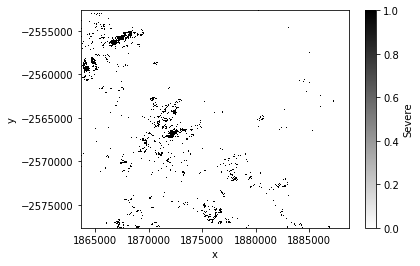

In [46]:
out.Severe.plot.imshow(cmap='binary')